<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_processing_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pystac_client
!pip install rasterio
# !pip install rio_cogeo
from pystac_client import Client as stac_client
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import dask
from dask.distributed import Client
import xarray as xr
import numpy as np

from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

import rasterio
from rasterio.windows import from_bounds
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
from rasterio.vrt import WarpedVRT


from cv2 import dilate
from shapely import bounds
from shapely.geometry import box, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

# from rio_cogeo import cogeo
from google.colab import drive
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime

import glob
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 85.2 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Functions

In [4]:
def intersects(item_bbox, poly):
    return shapely.box(*item_bbox).intersects(poly)


def scale_to_reflectance(dn):
    return dn.astype('float32') * 1e-4


def scale_to_8bit(dn):
    return (((dn + 1) / 2) * 255).astype('int8')


def normalized_difference(x, y):
    denominator = x + y
    normalized_diff = (x - y) / np.where(denominator != 0, denominator, np.nan)

    return normalized_diff

In [5]:
mode = 'all'

Import vector assets

In [6]:

if mode == 'all':
    square_path =('/content/drive/MyDrive/river_tinder_assets/all_sites/squares_15x_20250903.shp')
    pill_path =('/content/drive/MyDrive/river_tinder_assets/all_sites/pills_3L_3W_20250903.shp')
    circle_path =('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')
    pt_path = ('/content/drive/MyDrive/platte_pts_10000m.shp')

elif mode == 'gage':
    square_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_squares_15x_20250918.shp')
    pill_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_pills_3L_3W_20250918.shp')
    circle_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250918.shp')
    pt_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_20250918.shp')

elif mode == 'extra_gages':
    square_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_squares_15x_extra.shp')
    pill_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_pills_3L_3W_extra.shp')
    circle_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_extra.shp')
    pt_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_extra.shp')



centerline_path = ('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp')


def _init_worker(square_path, pill_path, circle_path, centerline_path, href_dict_in):
    global squares, pills, circles, vector_centerline, HREFS

    squares = gpd.read_file(square_path).set_index('iindex', drop=False).set_crs(4326)
    pills = gpd.read_file(pill_path).set_index('iindex', drop=False).set_crs(4326)
    circles = gpd.read_file(circle_path).set_index('iindex', drop=False).set_crs(4326)
    vector_centerline = gpd.read_file(centerline_path).set_crs(4326)

    HREFS = href_dict_in

Generate list of images for specified date range over study area

Pair images with buffer iindices

Write to csv for easy future access without redoing stac search

In [ ]:
squares = gpd.read_file(square_path).set_index('iindex', drop=False).set_crs(4326)
pts = gpd.read_file(pt_path).set_crs(4326)
pts = pts.loc[pts.iindex.isin(squares.index)]
pts = pts.set_index('iindex', drop=False)


stac = stac_client.open('https://earth-search.aws.element84.com/v1')

gage_search = stac.search(
    collections=['sentinel-2-l2a'],
    bbox=squares.total_bounds.tolist(),
    datetime='2018-01-01/2024-12-31',
    query={'eo:cloud_cover': {'lt': 20}},
    fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']}
)
items = list(gage_search.items())

work = []
for item in items:
    ibox = item.bbox
    b3_href = item.assets['green'].href
    b8_href = item.assets['nir'].href
    scl_href = item.assets['scl'].href

    for idx, row in pts.iterrows():
        if intersects(ibox, row.geometry):
            work.append((item, idx, b3_href, b8_href, scl_href))

id_hrefs = pd.DataFrame(work, columns=['img', 'iindex', 'b3_href', 'b8_href', 'scl_href'])

id_hrefs['img_id'] = id_hrefs.apply(lambda x: str(x['img']).split('=')[1][0:24], axis=1)
id_hrefs['mgrs'] = id_hrefs.apply(lambda x: x['img_id'].split('_')[1], axis=1)
id_hrefs['date'] = id_hrefs.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
id_hrefs['version'] = id_hrefs.apply(lambda x: x['img_id'].split('_')[3], axis=1)

# find duplicate images with different processing levels

tile_dts = []
tile_dt_versions = []
for row in tqdm(id_hrefs.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))


tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version'])\
    .sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = temp_df.head(1)
    nonduplicates.append(df_out)

nonduplicates = pd.concat(nonduplicates)



nonduplicate_id_hrefs = pd.merge(id_hrefs, nonduplicates[['mgrs', 'date', 'version']], how='right', on=['mgrs', 'date', 'version'])
nonduplicate_id_hrefs['year'] = nonduplicate_id_hrefs.apply(lambda x: x['date'].year, axis=1)
nonduplicate_id_hrefs['month'] = nonduplicate_id_hrefs.apply(lambda x: x['date'].month, axis=1)

nonduplicate_id_hrefs = nonduplicate_id_hrefs.set_index(['img_id', 'iindex'])

if mode == 'all':
    nonduplicate_id_hrefs.to_csv('/content/drive/MyDrive/all_sites/nonduplicate_stac_ids_hrefs_20250928.csv')
elif mode == 'extra_gages':
    nonduplicate_id_hrefs.to_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_extra.csv')
elif mode == 'gage':
    nonduplicate_id_hrefs.to_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_20250921.csv')
nonduplicate_id_hrefs

KeyboardInterrupt: 

Read image ids and buffer ids from csv

In [7]:
if mode == 'gage':
    nonduplicate_id_hrefs = pd.read_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_20250921.csv').set_index(['img_id', 'iindex'])
elif mode == 'all':
    nonduplicate_id_hrefs = pd.read_csv('/content/drive/MyDrive/river_tinder_assets/all_sites/nonduplicate_stac_ids_hrefs_20250928.csv')
elif mode == 'extra_gages':
    nonduplicate_id_hrefs = pd.read_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_extra.csv').set_index(['img_id', 'iindex'])
nonduplicate_id_hrefs

,img_id,iindex,img,b3_href,b8_href,scl_href,mgrs,date,version,year,month
0,S2A_13SED_20211104_0_L2A,34632,<Item id=S2A_13SED_20211104_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13SED,2021-11-04,0,2021,11
1,S2A_13TCG_20231021_0_L2A,79188,<Item id=S2A_13TCG_20231021_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCG,2023-10-21,0,2023,10
2,S2A_13TCG_20231021_0_L2A,110293,<Item id=S2A_13TCG_20231021_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCG,2023-10-21,0,2023,10
3,S2A_13TCG_20231021_0_L2A,61072,<Item id=S2A_13TCG_20231021_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCG,2023-10-21,0,2023,10
4,S2A_13TCG_20231021_0_L2A,75414,<Item id=S2A_13TCG_20231021_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCG,2023-10-21,0,2023,10
...,...,...,...,...,...,...,...,...,...,...,...
212740,S2B_13TCH_20190427_1_L2A,120369,<Item id=S2B_13TCH_20190427_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCH,2019-04-27,1,2019,4
212741,S2B_13TCH_20190427_1_L2A,120622,<Item id=S2B_13TCH_20190427_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCH,2019-04-27,1,2019,4
212742,S2B_13TCH_20190427_1_L2A,59163,<Item id=S2B_13TCH_20190427_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCH,2019-04-27,1,2019,4
212743,S2B_13TCH_20190427_1_L2A,60016,<Item id=S2B_13TCH_20190427_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TCH,2019-04-27,1,2019,4


In [8]:
stac = stac_client.open('https://earth-search.aws.element84.com/v1')
def search_stac_by_id(id):
    search = stac.search(collections=['sentinel-2-l2a'],
                         ids=[id],
                         fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']})

    # items = list(search.items())
    return list(search.items())[0]

In [9]:

def ref_geoms(img_id, poly_idx, view_geoms, otsu_geoms, effwidth_geoms, centerline_geoms):
    b3_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].b3_href
    with rasterio.open(b3_href) as src:
        img_crs = src.crs

    view_geom  = view_geoms.loc[poly_idx].geometry
    otsu_geom  = otsu_geoms.loc[poly_idx].geometry
    eff_geom   = effwidth_geoms.loc[poly_idx].geometry

    t_view  = Transformer.from_crs(view_geoms.crs, img_crs,  always_xy=True).transform
    t_otsu  = Transformer.from_crs(otsu_geoms.crs, img_crs,  always_xy=True).transform
    t_eff   = Transformer.from_crs(effwidth_geoms.crs, img_crs, always_xy=True).transform

    view_src = shp_transform(t_view, view_geom)
    otsu_src = shp_transform(t_otsu, otsu_geom)
    eff_src  = shp_transform(t_eff,  eff_geom)

    # Filter lines by intersection in image CRS, then reproject only those (cheap)
    if centerline_geoms.crs != img_crs:
        cl_img = centerline_geoms.to_crs(img_crs)
    else:
        cl_img = centerline_geoms
    hits = list(cl_img.sindex.query(otsu_src, predicate="intersects"))
    lines_in_bound = cl_img.iloc[hits].copy()

    return view_src, otsu_src, eff_src, lines_in_bound


def ref_geoms_from_b3href(b3_href, poly_idx, view_geoms, otsu_geoms, effwidth_geoms, centerline_geoms):
    with rasterio.open(b3_href) as src:
        img_crs = src.crs

    view_geom = view_geoms.loc[poly_idx].geometry
    otsu_geom = otsu_geoms.loc[poly_idx].geometry
    eff_geom = effwidth_geoms.loc[poly_idx].geometry

    t_view = Transformer.from_crs(view_geoms.crs, img_crs,  always_xy=True).transform
    t_otsu = Transformer.from_crs(otsu_geoms.crs, img_crs,  always_xy=True).transform
    t_eff = Transformer.from_crs(effwidth_geoms.crs, img_crs, always_xy=True).transform

    view_src = shp_transform(t_view, view_geom)
    otsu_src = shp_transform(t_otsu, otsu_geom)
    eff_src  = shp_transform(t_eff,  eff_geom)

    # Filter lines by intersection in image CRS, then reproject only those (cheap)
    if centerline_geoms.crs != img_crs:
        cl_img = centerline_geoms.to_crs(img_crs)
    else:
        cl_img = centerline_geoms
    hits = list(cl_img.sindex.query(otsu_src, predicate="intersects"))
    lines_in_bound = cl_img.iloc[hits].copy()

    return view_src, otsu_src, eff_src, lines_in_bound


def dn_to_reflectance(band):
    return np.float32(band) * 1e-4


def normalized_difference(b1, b2):
    denominator = b1 + b2
    numerator = b1 - b2
    return numerator / np.where(denominator != 0, denominator, np.nan)



def process_image(img_id, poly_idx, view_geom, otsu_geom):
    b3_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].b3_href
    b8_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].b8_href
    scl_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].scl_href


    l, b, r, t = view_geom.bounds

    # return l, b, r, t

    with rasterio.open(b3_href) as b3_src:
        wwindow = rasterio.windows.from_bounds(float(l), float(b), float(r), float(t), b3_src.transform).round_offsets().round_lengths()

        wwindow_transform = b3_src.window_transform(wwindow)

        b3v = b3_src.read(1, window=wwindow, masked=True)
        h, w = wwindow.height, wwindow.width
        b3_crs = b3_src.crs

    with rasterio.open(b8_href) as b8_src:
        b8v = b8_src.read(1, window=wwindow, masked=True)

    with rasterio.open(scl_href) as scl_src, WarpedVRT(
            scl_src,
            crs=b3_crs,
            transform=wwindow_transform, width=w, height=h,
            resampling=Resampling.nearest
         ) as vrt:
        sclv = vrt.read(1)
                        # , window=rasterio.windows.from_bounds(l, b, r, t, transform=scl_src.transform).round_offsets().round_lengths(), out_shape=(1, h, w), resampling=Resampling.nearest)

    sclv = np.ma.MaskedArray(sclv, mask=np.zeros_like(sclv, dtype=bool))
    b3v = dn_to_reflectance(b3v)
    b8v = dn_to_reflectance(b8v)

    ndwi_v = normalized_difference(b3v, b8v)

    otsu_geom_mask = geometry_mask([otsu_geom], out_shape=(h, w), transform=wwindow_transform, invert=True)

    # return ndwi_v, otsu_geom_mask, wwindow_transform
    if otsu_geom_mask.size <= ndwi_v.size:
        ndwi_o = np.ma.array(ndwi_v, mask=~otsu_geom_mask).compressed()
        b8o = np.ma.array(b8v, mask=~otsu_geom_mask).compressed()

        if ndwi_o.size >= 10:
            ndwi_threshold = threshold_otsu(ndwi_o)
            nir_threshold = threshold_otsu(b8o)
        else:
            ndwi_threshold = 1
            nir_threshold = 1

        wmask = (ndwi_v >= ndwi_threshold) & (b8v <= nir_threshold)

        cloudmask = np.isin(sclv, [7, 8, 9]).astype('uint8')
        snowmask = (sclv == 11).astype('uint8')
        ndmask = (sclv != 0).astype('uint8')

        return ndwi_v, wmask, cloudmask, snowmask, ndmask, wwindow_transform
    else:
        return np.array([1]), None, None, None, None, None


def process_image_from_hrefs(b3_href, b8_href, scl_href, view_geom, otsu_geom):
    l, b, r, t = map(float, view_geom.bounds)

    with rasterio.open(b3_href) as b3_src:
        window = rasterio.windows.from_bounds(l, b, r, t, b3_src.transform).round_offsets().round_lengths()
        transform = b3_src.window_transform(window)

        h, w = window.height, window.width

        if h == 0 or w == 0:
            return np.array([1]), None, None, None, None, None

        b3v = b3_src.read(1, window=window, masked=True)
        b3_crs = b3_src.crs

    with rasterio.open(b8_href) as b8_src:
        b8v = b8_src.read(1, window=window, masked=True)

    with rasterio.open(scl_href) as scl_src, WarpedVRT(
        scl_src, crs=b3_crs, transform=transform, width=w, height=h, resampling=Resampling.nearest
    ) as vrt:
        sclv = vrt.read(1)

    b3v = dn_to_reflectance(b3v)
    b8v = dn_to_reflectance(b8v)
    ndwi_v = normalized_difference(b3v, b8v)
    otsu_geom_mask = geometry_mask([otsu_geom], out_shape=(h, w), transform=transform, invert=True)
    # return otsu_geom_mask, ndwi_v
    if otsu_geom_mask.size <= ndwi_v.size:
        ndwi_o = np.ma.array(ndwi_v, mask=~otsu_geom_mask).compressed()
        b8o = np.ma.array(b8v, mask=~otsu_geom_mask).compressed()

        if ndwi_o.size >= 10:
            ndwi_threshold = threshold_otsu(ndwi_o)
            nir_threshold = threshold_otsu(b8o)
        else:
            ndwi_threshold = 1
            nir_threshold = 1

        wmask = (ndwi_v >= ndwi_threshold) & (b8v <= nir_threshold)

        cloudmask = np.isin(sclv, [7, 8, 9]).astype('uint8')
        snowmask = (sclv == 11).astype('uint8')
        ndmask = (sclv != 0).astype('uint8')

        return ndwi_v, wmask, cloudmask, snowmask, ndmask, transform
    else:
        return np.array([1]), None, None, None, None, None





def identify_river(wmask, lines, window_trans):
    h, w = wmask.shape
    wbool = wmask.filled(0) > 0
    # rbuffs = lines.copy().buffer(5)
    shapes = ((geom, 1) for geom in lines.geometry)
    river_seed = rasterize(
        shapes=shapes,
        out_shape= (h, w),
        transform=window_trans,
        fill=0,
        dtype='uint8',
        all_touched=True
    )
    structure = np.ones((3, 3), dtype=bool)
    river_mask = ndi.binary_propagation(input=river_seed * wbool, mask=wbool, structure=structure)
    return river_mask


def GENERATE_MASKS(img_id, poly_idx, squares, pills, circles, vector_centerlines):
    b3_href, b8_href, scl_href = HREFS[(img_id, poly_idx)]

    square, pill, circle_geom, lines = ref_geoms_from_b3href(b3_href, poly_idx, squares, pills, circles, vector_centerlines)

    ndwi_v, wmask, cloudmask, snowmask, ndmask, wwindow_transform = process_image_from_hrefs(b3_href, b8_href, scl_href, square, pill)
    # return process_image_from_hrefs(b3_href, b8_href, scl_href, square, pill)

    if ndwi_v.size > 1:

        rmask = identify_river(wmask, lines, wwindow_transform)

        return ndwi_v, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_geom
    else:
        return np.array([1]), None, None, None, None, None, None


def count_pixels(rmask, cloudmask, snowmask, ndmask, transform, circle):
    if rmask is not None:
        circle_mask = rasterize([circle], out_shape = rmask.shape, transform=transform, dtype='uint8', all_touched=True) == 1

        kernel = np.array([[0, 1, 0],
                        [1, 1, 1],
                        [0, 1, 0]]).astype('uint8')

        ring_mask = dilate(circle_mask.astype('uint8'), kernel, iterations=1) & ~circle_mask

        r = rmask.astype(bool)
        c = cloudmask.astype(bool)
        s = snowmask.astype(bool)
        v = ndmask.astype(bool)

        n_pixels = np.count_nonzero(circle_mask)
        n_valid = np.count_nonzero(circle_mask & v)
        n_river = np.count_nonzero(circle_mask & r)
        n_cloud = np.count_nonzero(circle_mask & c)
        n_snow = np.count_nonzero(circle_mask & s)
        n_cloudriver = np.count_nonzero(circle_mask & r & c)

        n_edge = np.count_nonzero(ring_mask)
        n_edgeriver = np.count_nonzero(ring_mask & r)

        return n_pixels, n_valid, n_river, n_cloud, n_snow, n_cloudriver, n_edge, n_edgeriver

    else:
        return -999, -999, -999, -999, -999, -999, -999, -999

In [10]:
def show_plot(img_id, poly_idx, squares, pills, circles, vector_centerlines):
    ndwi, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_poly = GENERATE_MASKS(img_id, poly_idx, squares, pills, circles, vector_centerlines)

    rm_cdict = {
            'red':   [[0.0, 0.0, 0.0],
                      [1.0, 1.0, 1.0]],
            'green': [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'blue':  [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'alpha': [[0.0, 0.0, 0.0],
                      [1.0, 0.35, 1.0]]
        }
    rm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=rm_cdict)

    cm_cdict = {
        'red':      [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'green':    [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'blue':     [[0.0, 0.0, 0.0],
                     [1.0, 1.0, 0.0]],
        'alpha':    [[0.0, 0.0, 0.0],
                     [1.0, 0.2, 1.0]]
    }
    cm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=cm_cdict)

    if ndwi.size > 1:
        fig, ax = plt.subplots()
        show(ndwi, cmap='Greys_r', ax=ax, transform=wwindow_transform)
        show(rmask, cmap=rm_cmap, ax=ax, transform=wwindow_transform)
        show(cloudmask, cmap=cm_cmap, ax=ax, transform=wwindow_transform)
        gpd.GeoSeries([circle_poly]).plot(ax=ax, facecolor='none')

    else:
        print('not enough in window')
    # tfig = plt.Figure()
    # ax_ndwi = tfig.add_subplot(1, 2, 1)
    # show(ndwi, cmap='Greys_r', ax=ax_ndwi)
    # ax_scl = tfig.add_subplot(1, 2, 2)
    # show(ndmask, cmap='Paired', ax=ax_scl)
    # tfig.suptitle(f'{img_id}_{poly_idx}')
    # tfig.tight_layout()

    # return fig

Get effective width at all gage sites in for loop\
Will identify good images after the fact using river tinder

In [13]:
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
year_imgs = {}
month_imgs = {}



href_dict = {(row.img_id, int(row.iindex)): (row.b3_href, row.b8_href, row.scl_href)
    for _, row in nonduplicate_id_hrefs.reset_index().iterrows()}

_init_worker(square_path, pill_path, circle_path, centerline_path, href_dict)


def _worker(args):
    img_id, idx = args
    # return idx
    try:
        ndwi, rmask, cloudmask, snowmask, ndmask, trans, circle_poly = GENERATE_MASKS(
            img_id, idx, squares, pills, circles, vector_centerline
        )
        if ndwi.size < 1:
            return(img_id, idx, -999, -999, -999, -999, -999, -999, -999, -999)

        return(img_id, idx, *count_pixels(rmask, cloudmask, snowmask, ndmask, trans, circle_poly))

    except Exception:
        return(img_id, idx, -999, -999, -999, -999, -999, -999, -999, -999)


paths = (square_path, pill_path, circle_path, centerline_path)

if mode == 'gage' or mode == 'extra_gages':

    for y in years:
        year_imgs[y] = (nonduplicate_id_hrefs.loc[nonduplicate_id_hrefs.year == y])

    with ProcessPoolExecutor(max_workers=min(4, mp.cpu_count()), initializer=_init_worker, initargs=(paths[0], paths[1], paths[2], paths[3], href_dict)) as ex:
        for y in years:
            path_out = (f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{y}_gx_20250927.csv')
            if path_out not in glob.glob(os.path.join('/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_*.csv')):

                tempdf = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.year == y)].copy()
                recs = tempdf.index.tolist()

                rows = list(tqdm(ex.map(_worker, recs, chunksize=8), total=len(recs), desc=str(y)))
                output = pd.DataFrame(rows, columns=['img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river', 'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver'])
                output.to_csv(path_out)

else:

    for y in years:
        for m in months:
            month_imgs[m] = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.month == m) & (nonduplicate_id_hrefs.year == y)].set_index(['img_id', 'iindex'])

        year_imgs[y] = month_imgs

    with ProcessPoolExecutor(max_workers=min(4, mp.cpu_count()), initializer=_init_worker, initargs=(paths[0], paths[1], paths[2], paths[3], href_dict)) as ex:
        for y in years:
            for m in months:
                path_out = (f'/content/drive/MyDrive/effwidth_results/all_sites/effwidths_{m}_{y}_20250928.csv')
                if path_out not in glob.glob(os.path.join('/content/drive/MyDrive/effwidth_results/all_sites/effwidths_*.csv')):

                    tempdf = year_imgs[y][m]
                    recs = tempdf.index.tolist()

                    rows = list(tqdm(ex.map(_worker, recs, chunksize=8), total=len(recs), desc=f'{y}_{m}'))
                    output = pd.DataFrame(rows, columns=['img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river', 'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver'])
                    output.to_csv(path_out)


2018:   0%|          | 0/2795 [00:05<?, ?it/s]
CRITICAL:concurrent.futures:Exception in initializer:
Traceback (most recent call last):
  File "/usr/lib/python3.12/concurrent/futures/process.py", line 243, in _process_worker
    initializer(*initargs)
  File "/tmp/ipython-input-2988632157.py", line 30, in _init_worker
    vector_centerline = gpd.read_file(centerline_path).set_crs(4326)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/geopandas/io/file.py", line 316, in _read_file
    return _read_file_pyogrio(
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/geopandas/io/file.py", line 576, in _read_file_pyogrio
    return pyogrio.read_dataframe(path_or_bytes, bbox=bbox, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py", line 275, in read_dataframe
    result = read_func(
             ^^^^^^^^^^
  File "/

KeyboardInterrupt: 

In [12]:
recs

[3296,
 3297,
 3298,
 3299,
 3300,
 3301,
 3302,
 3303,
 3304,
 3305,
 3306,
 3307,
 3308,
 3309,
 3310,
 3311,
 3312,
 3313,
 3314,
 3315,
 3316,
 3317,
 3318,
 3319,
 3320,
 3321,
 3322,
 4578,
 4579,
 4580,
 4842,
 4843,
 4844,
 4845,
 4846,
 4847,
 4848,
 4849,
 4850,
 4851,
 4852,
 4853,
 4854,
 5430,
 5431,
 5432,
 5433,
 5434,
 5435,
 5436,
 5437,
 5438,
 5439,
 5440,
 5441,
 5442,
 5443,
 5444,
 5445,
 5446,
 5447,
 5448,
 5449,
 5450,
 5451,
 5452,
 7912,
 7913,
 7914,
 7915,
 7916,
 7917,
 7918,
 7919,
 7920,
 7921,
 7922,
 7923,
 7924,
 7925,
 7926,
 7927,
 7928,
 7929,
 7930,
 7931,
 7932,
 7933,
 7934,
 7935,
 7936,
 7937,
 7938,
 7939,
 7940,
 7941,
 7942,
 7943,
 7944,
 7945,
 7946,
 7947,
 8170,
 8171,
 8172,
 9677,
 9678,
 9679,
 9680,
 9681,
 9682,
 9683,
 9684,
 9685,
 9686,
 9687,
 9688,
 9689,
 9690,
 9691,
 9692,
 9693,
 9694,
 9695,
 9696,
 9697,
 9698,
 9699,
 9700,
 9701,
 9702,
 9703,
 9754,
 9755,
 9756,
 9757,
 9758,
 9759,
 10267,
 10268,
 11315,
 11316,
 1

In [ ]:
output

,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver
0,S2B_13TEH_20241216_0_L2A,65735,286,286,35,0,0,0,56,5
1,S2B_13TEH_20241216_0_L2A,65158,1709,1709,194,0,0,0,135,7
2,S2B_13TEH_20241216_0_L2A,57082,7988,7988,435,0,0,0,288,12
3,S2A_13TEE_20241201_0_L2A,33809,74,74,19,0,0,0,30,4
4,S2A_13TEE_20241201_0_L2A,34632,-999,-999,-999,-999,-999,-999,-999,-999
5,S2A_13TEE_20241201_0_L2A,40608,72,72,12,0,0,0,30,5
6,S2A_13TEE_20241201_0_L2A,37091,308,308,46,0,0,0,58,4
7,S2A_13TEE_20241201_0_L2A,32788,41,41,11,0,0,0,23,4
8,S2A_13TEE_20241201_0_L2A,128275,40,40,32,0,0,0,24,15
9,S2A_13TEE_20241201_0_L2A,24573,73,73,19,0,0,0,30,6


In [ ]:
nonduplicate_id_hrefs

img  \
img_id                   iindex                                       
S2B_13TEH_20241216_0_L2A 65735   <Item id=S2B_13TEH_20241216_0_L2A>   
                         65158   <Item id=S2B_13TEH_20241216_0_L2A>   
                         57082   <Item id=S2B_13TEH_20241216_0_L2A>   
S2A_13TEE_20241201_0_L2A 33809   <Item id=S2A_13TEE_20241201_0_L2A>   
                         34632   <Item id=S2A_13TEE_20241201_0_L2A>   
...                                                             ...   
S2B_14TPL_20241107_0_L2A 94158   <Item id=S2B_14TPL_20241107_0_L2A>   
                         95006   <Item id=S2B_14TPL_20241107_0_L2A>   
                         127005  <Item id=S2B_14TPL_20241107_0_L2A>   
                         132646  <Item id=S2B_14TPL_20241107_0_L2A>   
                         106386  <Item id=S2B_14TPL_20241107_0_L2A>   

                                                                           b3_href  \
img_id                   iindex                                                      
S2B_13TEH_20241216_0_L2A 65735   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         65158   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         57082   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2A_13TEE_20241201_0_L2A 33809   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         34632   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
...                                                                            ...   
S2B_14TPL_20241107_0_L2A 94158   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         95006   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         127005  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         132646  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         106386  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   

                                                                           b8_href  \
img_id                   iindex                                                      
S2B_13TEH_20241216_0_L2A 65735   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         65158   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         57082   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2A_13TEE_20241201_0_L2A 33809   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         34632   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
...                                                                            ...   
S2B_14TPL_20241107_0_L2A 94158   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         95006   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         127005  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         132646  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         106386  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   

                                                                          scl_href  \
img_id                   iindex                                                      
S2B_13TEH_20241216_0_L2A 65735   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         65158   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         57082   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2A_13TEE_20241201_0_L2A 33809   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         34632   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
...                                                                            ...   
S2B_14TPL_20241107_0_L2A 94158   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         95006   https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         127005  https://s

In [ ]:
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
year_imgs = {}
month_imgs = {}
for y in years:
    for m in months:
        month_imgs[m] = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.month == m) & (nonduplicate_id_hrefs.year == y)]

    year_imgs[y] = month_imgs

len(year_imgs[2018][11]) + len(year_imgs[2018][12])

4248

In [ ]:
tid = 'S2B_15TTF_20240218_0_L2A'
tidx = 246043
b3_href = nonduplicate_id_hrefs.loc[tid, tidx].b3_href
b8_href = nonduplicate_id_hrefs.loc[tid, tidx].b8_href
scl_href = nonduplicate_id_hrefs.loc[tid, tidx].scl_href

square, pill, circle, lines = ref_geoms_from_b3href(b3_href, tidx, squares, pills, circles, vector_centerline)

ndwi, water, cloud, snow, ndmask, transform = process_image_from_hrefs(b3_href, b8_href, scl_href, square, pill)
river = identify_river(water, lines, transform)

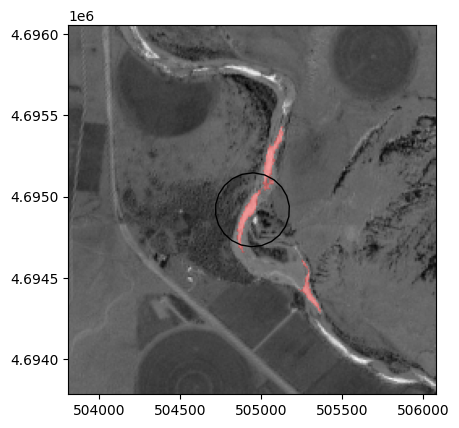

In [ ]:
timg = 'S2B_13TEH_20241216_0_L2A'
tindx = 65158
show_plot(timg, tindx, squares, pills, circles, vector_centerline)

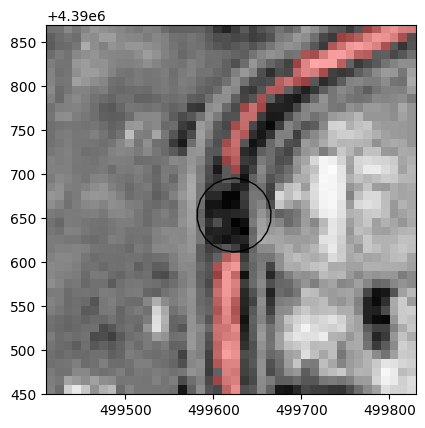

In [ ]:
timg = 'S2B_13SDD_20210406_1_L2A'
tindx = 38194
show_plot(timg, tindx, squares, pills, circles, vector_centerline)